In [4]:
#import all dependencies

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [50]:
#Reading data
rnaseq = pd.read_csv("G9_liver_gene-expr.csv")
mystery = pd.read_csv("mystery_gene-expr.csv")

#Pre-processing data
rnaseq.dropna()
rnaseq.iloc[:, 1].unique()
rnaseq.rename(columns = {'Primary Tumor':'0'})

mystery.dropna()
mystery.iloc[:, 1].unique()
mystery.rename(columns = {'Primary Tumor':'0'})

#Defining dependant variable
y = rnaseq['Label'].values
y_myst = mystery['Label'].values

#Encoding categorical data
Labelencoder = LabelEncoder()
Y_encoding = Labelencoder.fit_transform(y) # Primary Tumor = 0, Solid Tissue Normal = 1
y_mystencoding = Labelencoder.fit_transform(y_myst)

# Define the independent variables to drop the Label and Unnamed: 0
X = rnaseq.drop(labels = ['Label','Unnamed: 0'], axis = 1)
X_myst = mystery.drop(labels = ['Label','Unnamed: 0'], axis = 1)

feature_names = np.array(X.columns)

In [46]:
#Normalisation
scaler = StandardScaler()
scaler.fit(X)
X_scale = scaler.transform(X)
X_log2 = np.log2(X)

scaler.fit(X_myst)
X_mystscale = scaler.transform(X_myst)
X_mystlog2 = np.log2(X_myst)

#X_log2 = scaler.fit_transform(X_log2)
X_train, X_test, Y_train, Y_test = train_test_split(X_scale, Y_encoding, test_size = 0.3, random_state = 42)
#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)

c:\Users\oolba\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)
c:\Users\oolba\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)


In [7]:
# Hyperparameters
learning_rate = 0.00013
epochs = 1000

# Variables for controlling the test example
test_example = torch.tensor(X_test, dtype=torch.float32)


# Variables
X = torch.tensor(X_train, dtype=torch.float32)
Y = torch.tensor(Y_train, dtype=torch.float32)
w = torch.tensor(0.0, requires_grad=True)
b = torch.tensor(0.0, requires_grad=True)


num_samples, num_features = X.shape


input_size = num_features
output_size = num_samples

class Detector(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super(Detector, self).__init__()    
        self.lin = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        return self.lin(x)

model = Detector(input_size, output_size)    


loss = nn.MSELoss()
loss_over_time = []
optimiser = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [8]:
# Training loop
for epoch in range(epochs):

    total_loss = 0
    
    for i in range(num_samples):

        # Forward pass
        y_pred = model(X[i])
    
        # Calculate Loss
        l = loss(y_pred, Y[i])
        
        # Calculate gradients
        l.backward()

        total_loss += float(l)
    
    print(total_loss)
    loss_over_time.append(total_loss)
    # Update weights
    optimiser.step()
    optimiser.zero_grad()

c:\Users\oolba\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([294])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


134.93234924227
104.97615692019463
90.1532429382205
81.08333928883076
74.57721845060587
69.45136956125498
65.20248528569937
61.577196799218655
58.425975885242224
55.64960091933608
53.17713324353099
50.955508690327406
48.94384863600135
47.110011257231236
45.428324334323406
43.87801056355238
42.44206875562668
41.106450613588095
39.85944011434913
38.691189382225275
37.59335710853338
36.55882803723216
35.58149024285376
34.65606305748224
33.77795281261206
32.943146385252476
32.14811356924474
31.389734717085958
30.665241917595267
29.9721646476537
29.308292434550822
28.67163659259677
28.060400411486626
27.472958652302623
26.907834466546774
26.36367955803871
25.83926394302398
25.333456964232028
24.845222540199757
24.37360497098416
23.91772007010877
23.47675205208361
23.049944010563195
22.636592564173043
22.236042564734817
21.847684557549655
21.470947958528996
21.10530128981918
20.75024526566267
20.405312386341393
20.070063105784357
19.74408479873091
19.426988747902215
19.11840978031978
18.8180

20531
True positives:  14
True negatives:  88
False positives:  0
False negatives:  0
Accuracy:  1.0


Text(0, 0.5, 'Total Mean Squared Error')

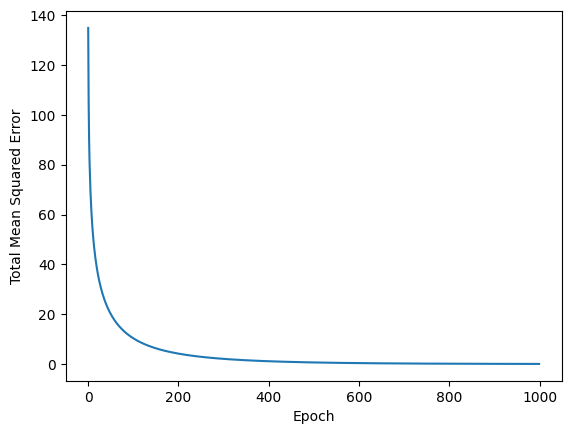

In [20]:
with torch.inference_mode():
    prediction = model(test_example)
    #print(f'Prediction after training = {test_example.item()} * {factor} = {prediction.item():.3f}')
rounded_prediction = []
mean = 0;
for row in prediction:
    mean = int(torch.round(torch.mean(row)))
    rounded_prediction.append(mean)

print(len(test_example[1]))

tp = 0
tn = 0
fp = 0
fn = 0
i = 0
for val in Y_test:
    if val == 1 and rounded_prediction[i] == 1:
        tp += 1
    if val == 0 and rounded_prediction[i] == 0:
        tn += 1
    if val == 0 and rounded_prediction[i] == 1:
        fp += 1
    if val == 1 and rounded_prediction[i] == 0:
        fn += 1
    i += 1

print("True positives: ", tp)
print("True negatives: ", tn)
print("False positives: ", fp)
print("False negatives: ", fn)
print("Accuracy: ", ((tn+tp)/(tp+tn+fp+fn)))

plt.plot(loss_over_time)
plt.xlabel("Epoch")
plt.ylabel("Total Mean Squared Error")

In [51]:
new_X = []
for subarr in X_mystscale:
    new_X.append(subarr[np.isfinite(subarr)])




Xmyst = torch.tensor(new_X, dtype=torch.float32)
Ymyst = torch.tensor(y_mystencoding, dtype=torch.float32)


with torch.inference_mode():
    prediction = model(Xmyst)
    #print(f'Prediction after training = {test_example.item()} * {factor} = {prediction.item():.3f}')
rounded_prediction = []
mean = 0;
for row in prediction:
    mean = int(torch.round(torch.mean(row)))
    rounded_prediction.append(mean)


tp = 0
tn = 0
fp = 0
fn = 0
i = 0
for val in Ymyst:
    if val == 1 and rounded_prediction[i] == 1:
        tp += 1
    if val == 0 and rounded_prediction[i] == 0:
        tn += 1
    if val == 0 and rounded_prediction[i] == 1:
        fp += 1
    if val == 1 and rounded_prediction[i] == 0:
        fn += 1
    i += 1

    print("True positives: ", tp)
    print("True negatives: ", tn)
    print("False positives: ", fp)
    print("False negatives: ", fn)
    print("Accuracy: ", ((tn+tp)/(tp+tn+fp+fn)))


True positives:  0
True negatives:  1
False positives:  0
False negatives:  0
Accuracy:  1.0
True positives:  0
True negatives:  2
False positives:  0
False negatives:  0
Accuracy:  1.0
True positives:  0
True negatives:  3
False positives:  0
False negatives:  0
Accuracy:  1.0
True positives:  0
True negatives:  4
False positives:  0
False negatives:  0
Accuracy:  1.0
True positives:  0
True negatives:  5
False positives:  0
False negatives:  0
Accuracy:  1.0
True positives:  0
True negatives:  6
False positives:  0
False negatives:  0
Accuracy:  1.0
True positives:  0
True negatives:  7
False positives:  0
False negatives:  0
Accuracy:  1.0
True positives:  0
True negatives:  8
False positives:  0
False negatives:  0
Accuracy:  1.0
True positives:  0
True negatives:  9
False positives:  0
False negatives:  0
Accuracy:  1.0
True positives:  0
True negatives:  10
False positives:  0
False negatives:  0
Accuracy:  1.0
True positives:  0
True negatives:  11
False positives:  0
False nega